In [14]:
import sys
import os
import time

import numpy as np
import scipy.ndimage
import pandas as pd
import matplotlib.pyplot as plt

from osgeo import gdal
from osgeo import osr
from osgeo.gdalconst import *
driver = gdal.GetDriverByName('GTiff')
driver.Register()

driver = gdal.GetDriverByName('GTiff')
driver.Register()





2

In [15]:
def createRaster(filename, array, coords_system, resol, origin, nodata=-9999, dtype=GDT_Float32):
    '''creates a raster out of a 2D array of values'''
    print(filename)
    rows, cols = array.shape
    pixelWidth, pixelHeight = resol, resol
    originX = origin[0]
    originY = origin[1]
    
    ds = driver.Create(filename, cols, rows, 1, GDT_Float32)
    ds.SetGeoTransform((originX, pixelWidth, 0, originY, 0, -pixelHeight))
    band = ds.GetRasterBand(1)
    band.WriteArray(array)
    band.FlushCache()
    band.SetNoDataValue(-9999)
    ds.SetProjection(coords_system.ExportToWkt())
    
    ds = None

In [3]:
coords_system = osr.SpatialReference()
coords_system.ImportFromEPSG(26915)


    

def checkCreatedRaster(dem):
    ds = gdal.Open(dem, GA_ReadOnly)
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    band = ds.GetRasterBand(1)
    elev = band.ReadAsArray(0, 0, cols, rows)
    value = elev[0, 2] 
    print(value)
    
dem = "simple_dem_1x3.tif"
elev = np.array([[203.0, 202.0, 201.0]])
resol = 10
createRaster(dem, elev, resol)
checkCreatedRaster(dem)





#junk
def plotRaster():
    fig, ax = plt.subplots(figsize = (10,10))
    ax.imshow(np.digitize(elev, [201,202,203]))
    plt.show()
    print("\n\n\n")
    #outData = numpy.zeros((rows,cols), numpy.int16)

    raster_plot = rasterio.open(raster)
    rasterio.plot.show(raster_plot, cmap='Reds')


201.0


In [16]:
def calculate_Qin_D8(Qin_array, Qout_array, direction):
    '''calculates Qin in each cell based on receiving Qout from neighboring cell(s)'''
    
    Qin_array += np.where(np.roll(direction, (-1,1), (1,0)) == 1,
                                      np.roll(Qout_array, (-1,1), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (0,1), (1,0)) == 2,
                                      np.roll(Qout_array, (0,1), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (1,1), (1,0)) == 3,
                                      np.roll(Qout_array, (1,1), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (-1,0), (1,0)) == 4,
                                      np.roll(Qout_array, (-1,0), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (0,0), (1,0)) == 5,
                                      0,
                                      0) #5 is the outlet, must force discharge out
    Qin_array += np.where(np.roll(direction, (1,0), (1,0)) == 6,
                                      np.roll(Qout_array, (1,0), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (-1,-1), (1,0)) == 7,
                                      np.roll(Qout_array, (-1,-1), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (0,-1), (1,0)) == 8,
                                      np.roll(Qout_array, (0,-1), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (1,-1), (1,0)) == 9,
                                      np.roll(Qout_array, (1,-1), (1,0)),
                                      0)

In [51]:
def applySMVE(deltaS, previous_H_array, previous_d, 
              psi_array, theta_array, K_array,
              deltatheta, eta, fi, resol):
    '''Takes in a water storage variation deltaS and redistributes it between the saturated (groundwater) and the unsaturated
    (soil moisture) parts of the aquifer. Applies Soil Moisture Velocity Equation (SMVE) with moisture (theta) bins.
    Returns the variation of the groundwater table (deltad), moisture quantity as height in each bin (current_H_array)
    and updated factor eta related to specific yield, which changes with groundwater table height (Sy = eta * fi)'''
    exit_condition = False
    rows, cols, num_bins = previous_H_array.shape
    error_tolerance = 0.02 * (fi * resol**2)
    error_prediction = np.full((rows, cols), error_tolerance + 1)
    previous_Vcapill_array = previous_H_array * deltatheta * resol**2
    previous_Vcapill = np.sum(previous_Vcapill_array, axis=2)
    previous_d_array = np.repeat(previous_d, num_bins).reshape(rows,cols,num_bins)
    working_psi_array = np.copy(psi_array)
    working_psi_array = np.where(np.less(D-previous_d_array-previous_H_array, 0.1),
                                 psi_b,
                                 working_psi_array)
    count = 1
    while exit_condition == False and count<10:
        print(count, eta)
        deltad = deltaS / (eta * fi * resol**2)
        deltad = np.where(previous_d + deltad > D,
                          D - previous_d,
                          deltad)
        deltad = np.where(previous_d + deltad < 0,
                          -previous_d,
                          deltad)
        working_d = previous_d + deltad
        deltad_array = np.repeat(deltad, num_bins).reshape(rows,cols,num_bins)
        d_array = np.repeat(working_d, num_bins).reshape(rows,cols,num_bins)
        
        H_array = np.copy(previous_H_array)
        i_ = np.argmax(H_array, axis=2, out=np.empty((rows,cols), dtype='int64'))
        #i_ = np.array([[]])
        H_array[:,:,:] -= deltad_array  #the level of every bin goes up or down the same quantity deltad, then readjust
        H_array = np.where(np.greater(d_array+H_array, D),
                           D-d_array,
                           H_array)        
        K_array_i = K_array[np.repeat(np.arange(rows), cols),
                            np.repeat(np.arange(cols), rows, axis=0).flatten(),
                            i_.flatten()].reshape(rows, cols, 1)
        theta_array_i = theta_array[np.repeat(np.arange(rows), cols),
                                    np.repeat(np.arange(cols), rows, axis=0).flatten(),
                                    i_.flatten()].reshape(rows, cols, 1)
        print("H_array", H_array)
        print("theta_array_i", theta_array_i)
        print("theta_array", theta_array)
        print("K_array_i", K_array_i)
        print("K_array", K_array)
        print("working_psi_array", working_psi_array)
        working_H_array = H_array + (K_array - K_array_i)/(theta_array - theta_array_i)*(working_psi_array/H_array - 1)
        working_H_array = np.where(np.greater(d_array+working_H_array, D),
                                  D-d_array,
                                  working_H_array)
        working_H_array = np.where(np.less(working_H_array, 0),
                                  0,
                                  working_H_array)
        
        current_Vcapill_array = working_H_array * deltatheta * resol**2
        current_Vcapill = np.sum(current_Vcapill_array, axis=2)
        delta_Vcapill = current_Vcapill - previous_Vcapill
        predicted_deltaS = delta_Vcapill + deltad * (fi * resol**2)
        error_prediction = deltaS - predicted_deltaS
        
        #print("error_prediction", error_prediction)
        if  np.all(abs(error_prediction) <= error_tolerance):
            exit_condition = True
        else:
            # means didn't add (remove) enough water, then have to increase eta
            eta += np.where(error_prediction < -error_tolerance,
                           np.minimum(abs(error_prediction)/error_tolerance, 0.05),
                           0)
                    # means we did add (remove) too much water, then have to decrease eta
            eta -= np.where(error_prediction > error_tolerance,
                           np.minimum(abs(error_prediction)/error_tolerance, 0.05),
                           0)
            # constrain eta to be a factor between 0 and 1 (actually 0.02 and 0.98)
            eta = np.where(eta >= 1,
                          0.98,
                          eta)
            eta = np.where (eta <= 0,
                           0.02,
                           eta) 
            
        count += 1
        
    current_H_array = -np.sort(-working_H_array)
    
    return deltad, current_H_array, eta 

In [41]:
def drainTheWatershed(watershed_cells, elevationValues, tanbetaValues, lddValues, resol, structure, run_foldername,
                       originX, originY, outlet_cell, gauges_cells,
                       Area_ratio_list, normalized_Vsoilwater_list, saturFront_list,
                       waterSoilStorageValues, wTableHeightValues, 
                       total_area, saturatedWatershedSoilWaterVolume,
                       D, fi, Sy, Ks, m, psi_b, n_days, deltat=1, 
                       decaying_transmissivity=True):
    '''
    This function simulates the draining of the aquifer from a condition of complete saturation of the whole watershed.
    The purpose is to related ratio of saturated areas over total area AND water content in the soil of the watershed.
    Both quantities are calculated and recorded at each time step.
        
    ### Input parameters ###
    watershed_cells: array of cells that are part of the watershed (excludes all the NA, null value cells)
    elevationValues: array of elevation values of cells, i.e. DEM values
    tanbetaValues: array of local slope of each cell
    lddValues: flow direction according to D8 scheme
    gauge_cells: list of cells where values are printed out (x,y as in coordinate system, not array coords)
    Area_ratio_list: saturated area over total area at each time step
    normalized_Vsoilwater_list: water in the soil (storage) at each time step, normalized by saturatedWatershedSoilWaterVolume    
    waterSoilStorageValues: array of volumetric water content of cells, in saturated conditions (we don't count water in unsat)
    wTableHeightValues: array of thickness of groundwater table, measured from the bottom (bedrock/impervious)
    total_area: area of the watershed
    saturatedWatershedSoilWaterVolume: max possible water volume when all cells in the watershed are saturated
    D: thickness of aquifer in full saturated condition; i.e. distance of ground surface from bottom (bedrock/impervious)
    fi: porosity of soil
    Sy: specific yield, proportion of water that flows laterally after groundwater table lowers of a quantity deltad
    Ks: hydraulic conductivity in saturated conditions
    m: coefficient of transmissivity decay
    psi_b: bubbling pressure (0.1 meters)
    n_days: number of days of simulation
    deltat: length of time step, in hours
    decaying transmissivity: True if assumption that transimissivity decays exponentially with saturated layer thickness
    '''
    
    rows, cols = elevationValues.shape
    initial_storage = waterSoilStorageValues
    stopping_condition = False
    

    #rate of change of saturated cells slows in time, so we use longer time steps as the simulation goes on in time
    n_steps = 24 * n_days
    if n_days <= 30:
        n_steps = n_days*24
    elif n_days <= 90:
        n_steps = 30*24 + (n_days-30)*4
    elif n_days <= 180:
        n_steps = 30*24 + 60*4 + (n_days-90)*2
    elif n_days <= 360:
        n_steps = 30*24 + 60*4 + 90*2 + (n_days-180)*1
    else:
        n_steps = 30*24 + 60*4 + 90*2 + 180*1 + (n_days-360)//7 + (n_days-360)%7
    printout_steps = np.geomspace(1, n_steps+1, 20, dtype=int)
    
    #here we calculate theta and hydraulic conductivity K.
    #Values are fixed in each cell, because the number of bins is fixed, and K is function of theta.
    #psi also function of theta, and should be fixed, BUT cannot go above (below in abs value) the bubbling pressure
    n_vG = 2.25
    m_vG = 1 - 1/n_vG
    alfa_vG = 9 #m^-1, equivalent to 0.09 cm^-1
    num_bins = 8
    theta_values = np.linspace(0.05, 0.45, num=num_bins)
    deltatheta = theta_values[1] - theta_values[0]
    theta_array = np.zeros((rows, cols, num_bins))
    theta_array[:,:] = theta_values
    THETA_array = (theta_array-theta_array[0,0,0]) / (theta_array[0,0,-1]-theta_array[0,0,0])
    Kr_array = np.sqrt(THETA_array) * np.power(1 - np.power(1-np.power(THETA_array,1/m_vG), m_vG), 2)
    K_array = Kr_array * Ks
    psi_array = (1/alfa_vG) * np.power(np.power(1/THETA_array, 1/m_vG), 1/n_vG)
    
    # for state variables we use dictionaries, where key is the time step and value is the array of values in the watershed
    Qin_dict = {}
    Qout_dict = {}
    Q_dict={}
    S_dict = {}
    E_dict = {}
    d_dict = {}
    runoffVol_dict = {}
    psi_dict = {}
    eta_dict = {} # Sy = eta * fi; fi is constant, Sy and eta change with gw table depth (smallest near surface)
    H_dict = {}
    #psi is capillarity, function of theta, thetas are fixed, so psi are fixed too. Unless there is no capillarity,
    #then psi = psi_b, bubbling pressure, smaller pressure (in abs value, capillarity is negative, against gravity)
    
    
    current_time = 0
    previous_outlet_satur_index = 0
    previous_contiguous_saturated = np.where(watershed_cells==1, 1, watershed_cells)
    previous_front = 0
    
    Qin_dict[current_time] = np.zeros((rows, cols))
    Qout_dict[current_time] = np.zeros((rows, cols))
    S_dict[current_time] = waterSoilStorageValues
    E_dict[current_time] = elevationValues
    d_dict[current_time] = wTableHeightValues
    runoffVol_dict[current_time] = np.zeros((rows, cols))
    # fixed num of bins = 7 + 1 bin after theta_e, where psi=psi_b and H=0
    psi_dict[current_time] = np.full((rows, cols, num_bins), psi_b)  
    eta_dict[current_time] = np.full((rows, cols), Sy/fi)
    #theta_dict[current_time] = np.zeros((rows, cols, 7))
    H_dict[current_time] = np.zeros((rows, cols, num_bins)) # initialize H in each bin, cell
    
    # full saturation at the beginning, then max theta at each z, means last bin is full, then all bins are full
    H_dict[current_time][:,:,:] = 0.001
    
    current_time += deltat
    while current_time < n_steps*deltat and stopping_condition == False:
        print("current time step: {}".format(current_time))
        
        # initialize cells to 0 for each status variable, just a way to set the size of arrays
        Qin_dict[current_time] = np.zeros((rows, cols))
        Qout_dict[current_time] = np.zeros((rows, cols))
        S_dict[current_time] = np.zeros((rows, cols))
        E_dict[current_time] = np.zeros((rows, cols))
        d_dict[current_time] = np.zeros((rows, cols))
        runoffVol_dict[current_time] = np.zeros((rows, cols))
        H_dict[current_time] = np.zeros((rows, cols, num_bins)) 
        
    
        previous_d = d_dict[current_time-deltat]
        previous_H_array = H_dict[current_time-deltat]
        eta = eta_dict[current_time-deltat]
        #T = K_array * previous_H
        T = Ks * previous_d
                
        if decaying_transmissivity == True:
            T = np.where(previous_d < (D - psi_b),
                         (Ks*D) * np.exp(-1*(D-psi_b-previous_d)*(eta*fi)/m),
                         T)

        # (actually no) need to transpose tanbetaValues to account for third dimension (theta bins). See below
        print(type(T), type(resol), type(tanbetaValues))
        print(T.shape, tanbetaValues.shape)
        print(resol)
        Qout = T * tanbetaValues * resol
        Qout_dict[current_time] = Qout
        direction = lddValues
        calculate_Qin_D8(Qin_dict[current_time], Qout_dict[current_time], direction)
        Qin = Qin_dict[current_time]

        #calculate current storage. Storage cannot be more than saturated condition and cannot be < 0
        deltaS = (Qin - Qout) * deltat
        #no_deltaS = np.where(deltaS == 0, 1, 0)
        previous_S = S_dict[current_time - deltat]
        runoffVol = np.where(np.greater(previous_S + deltaS, initial_storage),
                            (previous_S + deltaS - initial_storage)/deltat,
                            0)
        deltaS -= runoffVol
        deltaS = np.where(np.less(previous_S + deltaS, 0),
                         - previous_S,
                         deltaS)
        S = previous_S + deltaS
        S_dict[current_time] = S
        
        print("eta", eta)
        print("deltaS", deltaS)
        print("previous_H_array", previous_H_array)
        print("previous_d", previous_d)
        #calculate current thickness of saturated layer. Cannot be more than D=dmax and cannot be < 0
        # here is where we redistribute the moisture and find the actual d of the groundwater table
        deltad, current_H_array, eta = applySMVE(deltaS, previous_H_array, previous_d, 
                                                 psi_array, theta_array, K_array,
                                                 deltatheta, eta, fi, resol)
        print( deltad, current_H_array, eta)
        return

        d = previous_d + deltad
        #sy_dict[d] = eta*fi 
        d_dict[current_time] = d
        #commented line below are actually taken care in the applySMVE function already
        #d = np.where(d > D,
        #             D, 
        #             d)
        #d = np.where(d < 0, #previous_d + deltad < 0,
        #             0, 
        #             d)
        
        H_dict[current_time] = current_H_array
        eta_dict[current_time] = eta
        # if we want to recalculate the actual storage based on the actual d (saturated) and Hs in bins (unsaturated)
        #current_Vcapill_array = current_H_array * deltatheta * resol**2
        #current_Vcapill = np.sum(current_Vcapill_array, axis=2)
        #S = current_Vcapill + (fi * d * resol**2)
        #S_dict[current_time] = S
        
        
        #saturated area contributing to runoff to outlet
        saturated_cells = np.where(d>0.0, 0, d)
        saturated_cells = np.where(d >= (D-psi_b), 1, saturated_cells)
        contiguous_saturated = scipy.ndimage.label(saturated_cells, structure)[0]
        if current_time in [-1]:#10,20,50,100,150,200,250,300]:
            createRaster(run_foldername+watershed_nick+"_S_{}.tif".format(current_time),
                         S, coords_system, resol, [originX, originY])
            createRaster(run_foldername+watershed_nick+"_d_{}.tif".format(current_time),
                         d, coords_system, resol, [originX, originY])
            createRaster(run_foldername + watershed_nick + "_{}_saturated_cells.tif".format(current_time), 
                         saturated_cells, coords_system, resol, [originX, originY])
            
        
        outlet_satur_index = contiguous_saturated[outlet_cell[0]][outlet_cell[1]]
        #print(outlet_satur_index, outlet_cell[0], outlet_cell[1])
        if outlet_satur_index > 0:
            contiguous_saturated = np.where(d>0.0, contiguous_saturated, 0)
            contiguous_saturated = np.where(contiguous_saturated == outlet_satur_index, 1, 0)
            if current_time in printout_steps:#10,20,50,100,150,200,250,300]:
                createRaster(run_foldername + watershed_nick + "_{}_contiguous_saturated.tif".format(current_time), 
                             contiguous_saturated, coords_system, resol, [originX, originY], nodata=0)
        else:
            print("\n\nWARNING: the outlet turned unsaturated at time step {}.".format(current_time))
            contiguous_saturated = np.where(d>0.0, contiguous_saturated, 0)
            contiguous_saturated = np.where(contiguous_saturated > outlet_satur_index, 1, 0)
            createRaster(result_dir + watershed_nick + "_{}_end_contiguous_saturated.tif".format(current_time), 
                         contiguous_saturated, coords_system, resol, [originX, originY], nodata=0)
            stopping_condition = True
        
        
        #calculate saturated area in watershed, cells where groundwater table not below bubbling pressure distance 
        #from ground surface
        saturated_area = np.sum(contiguous_saturated) * resol * resol
        #print(current_time, saturated_area)
        area_ratio = saturated_area/total_area
        Area_ratio_list.append(area_ratio)
        
        # calculate sum of water content in soil for all cells, saturated and non-saturated
        watershed_soilStorage = np.where(watershed_cells==1, S, 0)
        watershedSoilWaterVolume = np.sum(watershed_soilStorage)
        normalized_Vsoilwater_list.append(watershedSoilWaterVolume/saturatedWatershedSoilWaterVolume)
        watershed_soilStorage = np.where(watershed_cells==1, S, None)
        
        #calculate front of saturated area
        #current_front = updateFront(previous_contiguous_saturated, contiguous_saturated, previous_front, d, current_time)
        #saturated_front = 0
        #saturated_front += np.sum(contiguous_saturated[:,1:] != contiguous_saturated[:,:-1])
        #saturated_front += np.sum(contiguous_saturated[1:,:] != contiguous_saturated[:-1,:])
        #saturated_front += np.sum(contiguous_saturated[0,:] == 1) + np.sum(contiguous_saturated[-1,:] == 1)
        #saturated_front += np.sum(contiguous_saturated[:,0] == 1) + np.sum(contiguous_saturated[:,-1] == 1)
        #saturFront_list.append(current_front*resol)
        #previous_contiguous_saturated = contiguous_saturated
        #previous_front = current_front


        #for gauge in gauges_cells:
            #print("At {} water table height (d) is : {}".format(gauge, d_dict[current_time][gauge[0]][gauge[1]]))
            #print("At {} water elevation is : {} m asl".format(gauge, E_dict[current_time][gauge[0]][gauge[1]]))
            #print("At {} water storage (S) is : {}".format(gauge, S_dict[current_time][gauge[0]][gauge[1]]))
            #print("At {} runoff is {} m^3\n".format(gauge, runoffVol_dict[current_time][gauge[0]][gauge[1]]))
        
        
        Qin_dict[current_time-deltat] = None
        Qout_dict[current_time-deltat] = None
        d_dict[current_time-deltat] = None
        S_dict[current_time-deltat] = None
        E_dict[current_time-deltat] = None
        runoffVol_dict[current_time-deltat] = None
        H_dict[current_time-deltat] = None
        eta_dict[current_time-deltat] = None
        
        if current_time in [-665,-666]:
            #filename = data_dir+watershed_nick+"_saturated_{}.tif".format(current_time)
            
            createRaster(run_foldername+watershed_nick+"_Qin_{}.tif".format(current_time),
                         Qin, coords_system, resol, [originX, originY])
            createRaster(run_foldername+watershed_nick+"_Qout_{}.tif".format(current_time),
                         Qout, coords_system, resol, [originX, originY])
            createRaster(run_foldername+watershed_nick+"_contiguous_saturated_{}.tif".format(current_time),
                         contiguous_saturated, coords_system, resol, [originX, originY], nodata=0)
            
        
        if current_time > 30*24:
            deltat = 6
        elif current_time > 30*24+60*4:
            deltat = 12
        elif current_time > 30*24+60*4+90*12:
            deltat = 24
        elif current_time > 30*24+60*4+90*12+180*1:
            deltat = 24*7
        
        current_time += deltat
    
    createRaster(run_foldername+watershed_nick+"_saturated.tif", 
                     saturated_cells, coords_system, resol, [originX, originY])
    createRaster(run_foldername+watershed_nick+"_d_end.tif", 
                     d, coords_system, resol, [originX, originY])
    createRaster(run_foldername+watershed_nick+"_S_end.tif", 
                     S, coords_system, resol, [originX, originY])
    
    for i in range(saturated_cells.shape[0]):
        for j in range(saturated_cells.shape[1]):
            if saturated_cells[i][j] == 1:
                x = originX + resol*j
                y = originY - resol*i
                #print(i,j,x,y)


    
    
def print_Aratio_SoilWatVol_relationship(filename, Area_ratio_list,normalized_Vsoilwater_list,saturFront_list):
    '''
    The function prints out the curve (corresponding values) to a txt file (filename).
    The curve can thus be reused later to estimate saturated excess contributing areas given 
    a certain amount of water in the soil
    '''
    relationship_df = pd.DataFrame({"AreaRatio": Area_ratio_list,
                                  "norm_SoilWatVol": normalized_Vsoilwater_list})
                                    #,
                                   #"Saturated_Front": saturFront_list})
    relationship_df.to_csv(filename, sep='\t')

In [27]:
def plotCurve(normalized_Vsoilwater_list, Area_ratio_list, saturFront_list,
              run_folder, watershed_name, watershed_nick,
              decaying_transmissivity, m):
    #plot the curve (saturated area ratio vs normalized soil water content) and save as jpg

    fig,ax = plt.subplots(figsize=(10,5.5))
    ax.set_title(watershed_name + ' - Saturated area ratio vs Soil water content', fontsize=20)
    ax.set_ylabel(r'$\frac{A_{sat}}{A_{tot}}$', fontsize=22, labelpad=22, rotation='horizontal')
    ax.set_xlabel("Normalized soil water content", fontsize=16, labelpad=0, rotation='horizontal')
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=13)

    spaced_xticks = [min(normalized_Vsoilwater_list),
                     min(normalized_Vsoilwater_list)+(max(normalized_Vsoilwater_list)-min(normalized_Vsoilwater_list))*0.25,
                     min(normalized_Vsoilwater_list)+(max(normalized_Vsoilwater_list)-min(normalized_Vsoilwater_list))*0.5,
                     min(normalized_Vsoilwater_list)+(max(normalized_Vsoilwater_list)-min(normalized_Vsoilwater_list))*0.75,
                     max(normalized_Vsoilwater_list)]
    #spaced_xticks = [0.0, 0.25, 0.5, 0.75, 1.0]
    print(spaced_xticks)
    ax.set_xticks(spaced_xticks)
    ax.set_xticklabels(['{0:.2f}'.format(spaced_xticks[0])+"\nNo area saturated",
                        '{0:.2f}'.format(spaced_xticks[1]),
                        '{0:.2f}'.format(spaced_xticks[2]),
                        '{0:.2f}'.format(spaced_xticks[3]),
                        '{0:.2f}'.format(spaced_xticks[-1])+"\nAll areas saturated"], 
                       fontsize=13)

    ax.plot(normalized_Vsoilwater_list, Area_ratio_list, color='k', linewidth=3)

    if decaying_transmissivity == False:
        plt.gcf().text(0.15, 0.8, "No transmissivity decay", 
                       fontsize=14, color='blue', fontweight="bold")
        fig.show()
        plt.savefig(run_folder + watershed_nick + "_satAreaRatio_SoilWaterVol_noDecay.jpg".format(m), dpi=85)
    else:
        plt.gcf().text(0.15, 0.8, "decay transmissivity\nparameter m = {}".format(m), 
                       fontsize=14, color='blue', fontweight="bold")
        fig.show()
        plt.savefig(run_folder + watershed_nick + "_satAreaRatio_SoilWaterVol_Decay_{}.jpg".format(m), dpi=85)

        

In [28]:
dir_path = os.path.realpath('./')
cwd = os.getcwd()

#################################### change watershed names/folders to area of interest! #########################
global watershed_name, watershed_foldername, watershed_nick, data_dir, result_dir, coords_system
watershed_name = "dem1x3"
watershed_foldername = "dem1x3"
watershed_nick = "dem1x3"
data_dir = (os.path.abspath(os.path.join(dir_path,'..')) + "/data/" + 
               watershed_foldername + os.path.sep)
result_dir = (os.path.abspath(os.path.join(dir_path,'..')) + "/model_results/" + 
               watershed_foldername + os.path.sep)
dem = data_dir + "simple_dem_1x3.tif"
tanbeta = data_dir + watershed_nick + "_tanbeta.tif"
ldd = data_dir + watershed_nick + "_ldd.tif"

################################### soil parameters ##############################################################
D = 2  #thickness of unconfined aquifer, shallow groundwater

#parameters for sandy loam  
Ks = 20  #micrometers per second
Ks = Ks * 3600 / 1000000  #meters per hour
decaying_transmissivity = False
m = 0.1  #this should be big number, so the exponent go to 0 (really? How big?)
psi_b = 0.1  #bubbling pressure / capillary head, for sand
fi = 0.45  #porosity
Sy = 0.24  #specific yield


################################# simulation run parameters ######################################################
n_days = 2000  #length of simulation
deltat = 1  #timestep
run_number = 1
outlet_coords = [25, 5] #array of points, one point (x,y) for each row, where to record values
#gauges_coords = [[759560, 4868910]] #array of points, one point (x,y) for each row, where to record values

elevations_ds = gdal.Open(dem, GA_ReadOnly)
band = elevations_ds.GetRasterBand(1)
cols = elevations_ds.RasterXSize
rows = elevations_ds.RasterYSize
print(rows, cols)
elevationValues = band.ReadAsArray(0, 0, cols, rows)
nodata = band.GetNoDataValue()
elevationValues = np.ma.masked_equal(elevationValues, nodata)
geotransform = elevations_ds.GetGeoTransform()
originX = geotransform[0]
originY = geotransform[3]
raster_origin = [originX, originY]
resol = np.round(geotransform[1])
print(originX, originY, resol)
#coords_system = osr.SpatialReference()
#coords_system.ImportFromEPSG(26919)
prj = elevations_ds.GetProjection()
coords_system = osr.SpatialReference(wkt=prj)
print(elevationValues)

tanbeta_array = np.array([[0.1, 0.1, 0.1]])
createRaster(tanbeta, tanbeta_array, coords_system, resol, raster_origin)
tanbeta_ds = gdal.Open(tanbeta, GA_ReadOnly)
band = tanbeta_ds.GetRasterBand(1)
tanbetaValues = band.ReadAsArray(0, 0, cols, rows)
nodata = band.GetNoDataValue()
tanbetaValues = np.ma.masked_equal(tanbetaValues, nodata)
tanbetaValues = np.where(tanbetaValues == 0, 0.01, tanbetaValues)
print(tanbetaValues)

createRaster(ldd, np.array([[6,6,5]]), coords_system, resol, raster_origin)
ldd_ds = gdal.Open(ldd, GA_ReadOnly)
band = ldd_ds.GetRasterBand(1)
lddValues = band.ReadAsArray(0, 0, cols, rows)
nodata = band.GetNoDataValue()
lddValues = np.ma.masked_equal(lddValues, nodata)
print(lddValues)
#lddValues = ma.masked_less(lddValues, 0)
ldd_dict = {1: [1, -1],
            2: [1, 0],
            3: [1, 1],
            4: [0, -1],
            5: [0, 0],
            6: [0, 1],
            7: [-1, -1],
            8: [-1, 0],
            9: [-1, 1]    
}
structure = [[1,1,1],
             [1,1,1],
             [1,1,1]]

1 3
10.0 10.0 10.0
[[203. 202. 201.]]
C:\Users\feder\Documents\CUAHSI\repos\Aquaholics_Anonymous/data/dem1x3\dem1x3_tanbeta.tif
[[0.1 0.1 0.1]]
C:\Users\feder\Documents\CUAHSI\repos\Aquaholics_Anonymous/data/dem1x3\dem1x3_ldd.tif
[[6. 6. 5.]]


In [29]:
#initialize to all cells saturated
waterStorageFile = data_dir + watershed_nick + "_storage.tif"
initial_storage = D*resol*resol*fi
waterStorageArray = np.where(elevationValues>0.0, initial_storage, None)
createRaster(waterStorageFile, waterStorageArray, coords_system, resol, raster_origin)
waterStorage_ds = gdal.Open(waterStorageFile, GA_ReadOnly)
waterStorage_geotransform = waterStorage_ds.GetGeoTransform()
#print(waterStorage_geotransform[0], waterStorage_geotransform[3], resol)
band = waterStorage_ds.GetRasterBand(1)
waterSoilStorageValues = band.ReadAsArray(0, 0, cols, rows)
saturatedWatershedWaterVolume = np.sum(waterSoilStorageValues)

wTableHeightFile = data_dir + watershed_nick + "_water_table_height.tif"
wTableHeightArray = np.where(elevationValues>0.0, D, None)
createRaster(wTableHeightFile, wTableHeightArray, coords_system, resol, raster_origin)
wTableHeight_ds = gdal.Open(wTableHeightFile, GA_ReadOnly)
tableHeight_geotransform = wTableHeight_ds.GetGeoTransform()
#print(tableHeight_geotransform[0], tableHeight_geotransform[3], resol)
band = wTableHeight_ds.GetRasterBand(1)
wTableHeightValues = band.ReadAsArray(0, 0, cols, rows)

# these lists contain the values to build the area ratio vs soil content curve
Area_ratio_list = []
normalized_Vsoilwater_list = []
saturFront_list = []
watershed_cells = np.where(elevationValues>0.0, 1, 0)
#createRaster(data_dir + watershed_nick + "_watershed_cells.tif", watershed_cells, coords_system, resol, raster_origin)
total_area = np.sum(watershed_cells) * resol * resol
watershed_cells = np.where(elevationValues>0.0, 1, None)
saturatedWatershedSoilStorage = np.where(watershed_cells==1, waterSoilStorageValues, 0)
saturatedWatershedSoilWaterVolume = np.sum(saturatedWatershedSoilStorage)


outlet_cell = list([-int((outlet_coords[1] - originY) / resol), int((outlet_coords[0] - originX) / resol)])
#gauges_cells = []
#for point in gauges_coords:
#    gauges_cells.append([-int((point[1] - originY) / resol), int((point[0] - originX) / resol)])
#print(gauges_coords, gauges_cells)


run_foldername = "{}_{}_{}".format(watershed_nick, n_days, run_number, m) + os.path.sep
if decaying_transmissivity == True:
    run_foldername = "{}_{}_{}_decay{}".format(watershed_nick, n_days, run_number, m) + os.path.sep
if not os.path.exists(run_foldername):
    os.mkdir(run_foldername)
#print(run_foldername)


C:\Users\feder\Documents\CUAHSI\repos\Aquaholics_Anonymous/data/dem1x3\dem1x3_storage.tif
C:\Users\feder\Documents\CUAHSI\repos\Aquaholics_Anonymous/data/dem1x3\dem1x3_water_table_height.tif


In [52]:
start_time = time.perf_counter()
drainTheWatershed(watershed_cells, elevationValues, tanbetaValues, lddValues, resol, structure, run_foldername,
                   originX, originY, outlet_cell, gauges_cells,
                   Area_ratio_list, normalized_Vsoilwater_list, saturFront_list,
                   waterSoilStorageValues, wTableHeightValues,
                   total_area, saturatedWatershedSoilWaterVolume,
                   D, fi, Sy, Ks, m, psi_b, n_days, deltat,
                   decaying_transmissivity)
if decaying_transmissivity == True:
    relationship_table_filename = run_foldername+watershed_nick+"_{}_{}_decay{}_ARatio_satFront_SoilWatVol.txt".format(n_days, run_number, m)
else:
    relationship_table_filename = run_foldername+watershed_nick+"_{}_{}_noDecay_ARatio_satFront_SoilWatVol.txt".format(n_days, run_number)
print_Aratio_SoilWatVol_relationship(relationship_table_filename,
                                     Area_ratio_list,
                                     normalized_Vsoilwater_list,
                                    saturFront_list)
print("\nSaturated area ratio at the end of the simulation is {}%.".format(100 * Area_ratio_list[-1]))
print("The model ran {} days in {} seconds in {} watershed.".format(n_days, 
                                                                    (time.perf_counter() - start_time),
                                                                    watershed_name))
    
plotCurve(normalized_Vsoilwater_list, Area_ratio_list, saturFront_list,
          run_foldername, watershed_name, watershed_nick,
          decaying_transmissivity, m)

C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in less_equal
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


current time step: 1
<class 'numpy.ndarray'> <class 'numpy.float64'> <class 'numpy.ndarray'>
(1, 3) (1, 3)
10.0
eta [[0.53333333 0.53333333 0.53333333]]
deltaS [[-0.14399999  0.          0.        ]]
previous_H_array [[[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
  [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
  [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]]]
previous_d [[2. 2. 2.]]
1 [[0.53333333 0.53333333 0.53333333]]
H_array [[[0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006]
  [0.    0.    0.    0.    0.    0.    0.    0.   ]
  [0.    0.    0.    0.    0.    0.    0.    0.   ]]]
theta_array_i [[[0.05]
  [0.05]
  [0.05]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.]
  [0.]
  [0.]]]
K_array [[[0.00000000

current time step: 2
<class 'numpy.ndarray'> <class 'numpy.float64'> <class 'numpy.ndarray'>
(1, 3) (1, 3)
10.0
eta [[0.53333333 0.53333333 0.53333333]]
deltaS [[-0.143568 -0.000432  0.      ]]
previous_H_array [[[0.006 0.006 0.006 0.006 0.006 0.006 0.006   nan]
  [0.    0.    0.    0.    0.    0.    0.      nan]
  [0.    0.    0.    0.    0.    0.    0.      nan]]]
previous_d [[1.994 2.    2.   ]]
1 [[0.53333333 0.53333333 0.53333333]]
H_array [[[1.19819998e-02 1.19819998e-02 1.19819998e-02 1.19819998e-02
   1.19819998e-02 1.19819998e-02 1.19819998e-02            nan]
  [1.79999995e-05 1.79999995e-05 1.79999995e-05 1.79999995e-05
   1.79999995e-05 1.79999995e-05 1.79999995e-05            nan]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00            nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10

C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


 [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]]]
working_psi_array [[[0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]
  [0.1        0.1        0.1        0.1     

   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]]]
working_psi_array [[[0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]]]
8 [[0.53333333 0.53333333 0.53333333]]
H_array [[[7.08238009e-02 7.08238009e-02 7.08238009e-02 7.08238009e-02
   7.08238009e-02 7.08238009e-02 7.08238009e-02            nan]
  [1.16447906e-03 1.16447906e-03 1.16447906e-03 1.16447906e-03
   1.16447906e-03 1.16447906e-03 1.16447906e-03            nan]
  [1.16417264e-05 1.16417264e-05 1.16417264e-05 1.16417264e-05
   1.16417264e-05 1.16417264e-05 1.16417264e-05            nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
 

H_array [[[1.01930803e-01 1.00424785e-01 9.83377579e-02 9.53168765e-02
   9.06676459e-02 8.26927994e-02 6.50827744e-02            nan]
  [2.97520940e-03 2.97520940e-03 2.97520940e-03 2.97520940e-03
   2.97520940e-03 2.97520940e-03 2.97520940e-03            nan]
  [5.04757807e-05 5.04757807e-05 5.04757807e-05 5.04757807e-05
   5.04757807e-05 5.04757807e-05 5.04757807e-05            nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.6646068

H_array [[[1.39139597e-01 1.39139597e-01 1.39139597e-01 1.39139597e-01
   1.39139597e-01 1.22740046e-01 1.10832069e-01            nan]
  [4.75449070e-03 4.75449070e-03 4.75449070e-03 4.75449070e-03
   4.75449070e-03 4.75449070e-03 4.75449070e-03            nan]
  [1.04253770e-04 1.04253770e-04 1.04253770e-04 1.04253770e-04
   1.04253770e-04 1.04253770e-04 1.04253770e-04            nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.6646068

H_array [[[0.10228523 0.08969761 0.0722538  0.05412332 0.04700463 0.02100259
   0.00814538        nan]
  [0.00789951 0.00789951 0.00789951 0.00789951 0.00789951 0.00789951
   0.00789951        nan]
  [0.00022792 0.00022792 0.00022792 0.00022792 0.00022792 0.00022792
   0.00022792        nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e

   0.000358          nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]]]
working_psi_array [[[0.1        0.1        0.1        0.1        0.1        0.1
   0.12569411 0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]
  [

theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]]]
working_psi_array [[[0.1        0.52703071 0.30269966 0.21884615 0.1738553  0.14543198
   0.12569411 0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.

   0.1        0.11111111]]]
9 [[0.53333333 0.53333333 0.53333333]]
H_array [[[0.15311259 0.13474691 0.10929592 0.07245672 0.01576003 0.00522551
   0.00522551        nan]
  [0.01779056 0.01779056 0.01779056 0.01779056 0.01779056 0.01779056
   0.01779056        nan]
  [0.00079325 0.00079325 0.00079325 0.00079325 0.00079325 0.00079325
   0.00079325        nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.200000

H_array [[[0.17663779 0.157023   0.12984101 0.09049625 0.02994344 0.00513215
   0.00513215        nan]
  [0.02241089 0.02241089 0.02241089 0.02241089 0.02241089 0.02241089
   0.02241089        nan]
  [0.00113073 0.00113073 0.00113073 0.00113073 0.00113073 0.00113073
   0.00113073        nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e

   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]]]
working_psi_array [[[0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]]]
3 [[0.53333333 0.53333333 0.53333333]]
H_array [[[0.32991147 0.32991147 0.32991147 0.32991147 0.32991147 0.32991147
   0.32991147        nan]
  [0.02839097 0.02839097 0.02839097 0.02839097 0.02839097 0.02839097
   0.02839097        nan]
  [0.00162611 0.00

   0.1        0.11111111]]]
5 [[0.53333333 0.53333333 0.53333333]]
H_array [[[0.3597485  0.3597485  0.3597485  0.3597485  0.3597485  0.3597485
   0.34128067        nan]
  [0.03400146 0.03400146 0.03400146 0.03400146 0.03400146 0.03400146
   0.03400146        nan]
  [0.00214556 0.00214556 0.00214556 0.00214556 0.00214556 0.00214556
   0.00214556        nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.2000000

   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]]]
working_psi_array [[[       inf 0.52703071 0.30269966 0.21884615 0.1738553  0.14543198
   0.12569411 0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]]]
7 [[0.53333333 0.53333333 0.53333333]]
H_array [[[0.25165554 0.22958053 0.19898919 0.15470955 0.08656179 0.00486197
   0.00486197        nan]
  [0.03900518 0.03900518 0.03900518 0.03900518 0.03900518 0.03900518
   0.03900518        nan]
  [0.00265012 0.00265012 0.00265012 0.00265012 0.00265012 0.00265012
   0.00265012        nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.3357

  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]]]
working_psi_array [[[       inf 0.52703071 0.30269966 0.21884615 0.1738553  0.14543198
   0.12569411 0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]
  [0.1        0.1        0.1        0.1        0.1      

   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]]]
working_psi_array [[[0.1        0.1        0.1        0.1        0.1        0.14543198
   0.12569411 0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]]]
8 [[0.53333333 0.53333333 0.53333333]]
H_array [[[0.43673366 0.43673366 0.43673366 0.43673366 0.36852919 0.31061781
   0.23918143        nan]
  [0.05101298 0.05101298 0.05101298 0.05101298 0.05101298 0.05101298
   0.05101298        nan]
  [0.004006

   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]]]
working_psi_array [[[0.1        0.1        0.1        0.1        0.1738553  0.14543198
   0.12569411 0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]]]
2 [[0.53333333 0.53333333 0.53333333]]
H_array [[[0.46466226 0.46466226 0.46466226 0.46446399 0.30551326 0.25247645
   0.2243501         nan]
  [0.05811344 0.05811344 0.05811344 0.05811344 0.05811344 0.05811344
   0.05811344        nan]
  [0.00489918 0.00489918 0.00489918 0.00489918 0.00489918 0.00489918
   0.00489918        nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.3357

H_array [[[0.4920919  0.4920919  0.4920919  0.46030561 0.305384   0.25376384
   0.22224308        nan]
  [0.06558228 0.06558228 0.06558228 0.06558228 0.06558228 0.06558228
   0.06558228        nan]
  [0.00590515 0.00590515 0.00590515 0.00590515 0.00590515 0.00590515
   0.00590515        nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e

   0.00683352        nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]]]
working_psi_array [[[       inf 0.52703071 0.30269966 0.21884615 0.1738553  0.14543198
   0.12569411 0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.111111

K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]]]
working_psi_array [[[0.1        0.1        0.1        0.1        0.1738553  0.14543198
   0.12569411 0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]
  [0.1        0.1        0.1        0.1        0.1        0.1
   0.1        0.11111111]]]
6 [[0.53333333 0.53333333 0.53333333]]
H_array [[[0.54548979 0.54548979 0.54548979 0.46354218 0.31559764 0.24809065
   0.22182639        nan]
  [0.08156376 0.08156376 0.08156376 0.08156376 0.08156376 0.08156376
   0.08156376        nan]
  [0.00827554 0.00827554 0.00827554 0.00827554 0.00827554 0.00827554
   0.0082755

H_array [[[0.42725839 0.40252654 0.36825338 0.30729335 0.14111261 0.02174954
   0.00428557        nan]
  [0.09149112 0.09149112 0.09149112 0.09149112 0.09149112 0.09149112
   0.09149112        nan]
  [0.00988898 0.00988898 0.00988898 0.00988898 0.00988898 0.00988898
   0.00988898        nan]]]
theta_array_i [[[0.45]
  [0.45]
  [0.45]]]
theta_array [[[0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]
  [0.05       0.10714286 0.16428571 0.22142857 0.27857143 0.33571429
   0.39285714 0.45      ]]]
K_array_i [[[0.072]
  [0.072]
  [0.072]]]
K_array [[[0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e-04
   2.70952280e-03 7.66460682e-03 1.98020416e-02 7.20000000e-02]
  [0.00000000e+00 7.72262237e-06 1.37147130e-04 7.65490788e

AttributeError: 'NoneType' object has no attribute 'SetGeoTransform'

In [ ]:
start_time = time.perf_counter()
drainTheWatershed(watershed_cells, elevationValues, tanbetaValues, lddValues, resol, structure, run_foldername,
                   originX, originY, outlet_cell, gauges_cells,
                   Area_ratio_list, normalized_Vsoilwater_list, saturFront_list,
                   waterSoilStorageValues, wTableHeightValues,
                   total_area, saturatedWatershedSoilWaterVolume,
                   D, fi, Sy, Ks, m, psi_b, n_days, deltat,
                   decaying_transmissivity)

In [150]:
def runDrainTheAquifer(elevationValues, waterStorageValues, wTableHeightValues, slope,
                       D, fi, Sy, Ks, m, psi_b, n_days, deltaT=1, decaying_transmissivity=True):
    '''
    elevationValues: array of elevation values of cells, i.e. DEM values
    waterStorageValues: array of volumetric water content of cells, in saturated conditions
    wTableHeightValues: array
    etc
    '''

    rows, cols = elevationValues.shape 
    n_steps = 24 * n_days
    Qdict = {}
    Sdict = {}
    Edict = {}
    ddict = {}
    runoffVol = 0
    outlet = [0,2]

    current_time = 0
    print("current time step: {}".format(current_time))
    Qdict[current_time] = np.zeros((rows, cols))
    Sdict[current_time] = waterStorageValues
    Edict[current_time] = elevationValues
    ddict[current_time] = wTableHeightValues
    print("water table height (d) is : {}".format(ddict[current_time]))
    print("water elevation is : {} m asl".format(Edict[current_time]))
    print("water storage (S) is : {}".format(Sdict[current_time]))
    print("cumulative runoff is {} m^3/s\n".format(runoffVol))

    current_time += deltaT
    while current_time < n_steps*deltaT:
        print("current time step: {}".format(current_time))
        Qdict[current_time] = np.zeros((rows, cols))
        Sdict[current_time] = np.zeros((rows, cols))
        Edict[current_time] = np.zeros((rows, cols))
        ddict[current_time] = np.zeros((rows, cols))
        for i in range(rows):
            for j in range(cols):
                previous_d = ddict[current_time-1][i,j]
                if decaying_transmissivity == True  and  previous_d < (D - psi_b):
                    T = (Ks*D) * np.exp(-1*(D-psi_b-previous_d)*(fi-Sy)/ m) #this is dynamic
                else:
                    T = Ks * previous_d
                Qout = T * resol * slope
                Qdict[current_time][i,j] = Qout
                if j>0:
                    Qin = Qdict[current_time][i,j-1]
                else:
                    Qin = 0

                if [i,j] == outlet:
                    runoffVol += Qout * deltaT

                deltaS = (Qin - Qout) * deltaT
                S = Sdict[current_time-1][i,j] + deltaS
                Sdict[current_time][i,j] = S

                deltad = deltaT*(Qin-Qout)/(Sy*resol*resol)
                d = ddict[current_time-1][i,j] + deltad
                if d > 0:
                    ddict[current_time][i,j] = d
                else:
                    ddict[current_time][i,j] = 0

                Edict[current_time][i,j] = Edict[0][i,j] - D + ddict[current_time][i,j]

        print("water table height (d) is : {}".format(ddict[current_time]))
        print("water elevation is : {} m asl".format(Edict[current_time]))
        print("water storage (S) is : {}".format(Sdict[current_time]))
        print("cumulative runoff is {} m^3\n".format(runoffVol))
        current_time += deltaT
    
    return ddict, Edict, Sdict, Qdict, runoffVol
    

D = 2  #thickness of unconfined aquifer, shallow groundwater
#parameters for sand  
Ks = 100 #micrometers per second
Ks = Ks * 3600 / 1000000 #meters per hour
decaying_transmissivity = True
m = 0.1 #this should be big number, so the exponent go to 0 (really?)
psi_b = 0.1 #bubble "thing" / capillary head, for sand
fi = 0.3
Sy = 0.15
n_days = 10
deltaT = 1


elevations_ds = gdal.Open(dem, GA_ReadOnly)
band = elevations_ds.GetRasterBand(1)
elevationValues = band.ReadAsArray(0, 0, elevations_ds.RasterXSize, elevations_ds.RasterYSize)

waterStorageFile = "storage.tif"
initial_storage = D*resol*resol*fi
waterStorageArray = np.array([[initial_storage, initial_storage, initial_storage]])
createRaster(waterStorageFile, waterStorageArray, resol)
waterStorage_ds = gdal.Open(waterStorageFile, GA_ReadOnly)
band = waterStorage_ds.GetRasterBand(1)
waterStorageValues = band.ReadAsArray(0, 0, waterStorage_ds.RasterXSize, waterStorage_ds.RasterYSize)

wTableHeightFile = "water_table_height.tif"
wTableHeightArray = np.array([[D, D, D]])
createRaster(wTableHeightFile, wTableHeightArray, resol)
wTableHeight_ds = gdal.Open(wTableHeightFile, GA_ReadOnly)
band = wTableHeight_ds.GetRasterBand(1)
wTableHeightValues = band.ReadAsArray(0, 0, wTableHeight_ds.RasterXSize, wTableHeight_ds.RasterYSize)

slopeFile = "slope.tif"
slope = np.absolute((elevationValues[0, 2] - elevationValues[0, 0]) / (2*resol))
#slopeArray = np.array([[slope, slope, slope]])
#createRaster(slopeFile, slopeArray, resol)

simul_results = runDrainTheAquifer(elevationValues, waterStorageValues, wTableHeightValues, slope,
                                   D, fi, Sy, Ks, m, psi_b, n_days, deltaT, decaying_transmissivity)



current time step: 0
water table height (d) is : [[2. 2. 2.]]
water elevation is : [[203. 202. 201.]] m asl
water storage (S) is : [[60. 60. 60.]]
cumulative runoff is 0 m^3/s

current time step: 1
water table height (d) is : [[1.952 2.    2.   ]]
water elevation is : [[202.952 202.    201.   ]] m asl
water storage (S) is : [[59.28 60.   60.  ]]
cumulative runoff is 0.72 m^3

current time step: 2
water table height (d) is : [[1.905152 1.998848 2.      ]]
water elevation is : [[202.905152 201.998848 201.      ]] m asl
water storage (S) is : [[58.57728 59.98272 60.     ]]
cumulative runoff is 1.44 m^3

current time step: 3
water table height (d) is : [[1.85942835 1.9965993  1.99997235]]
water elevation is : [[202.85942835 201.9965993  200.99997235]] m asl
water storage (S) is : [[57.89142528 59.94898944 59.99958528]]
cumulative runoff is 2.16 m^3

current time step: 4
water table height (d) is : [[1.8142624  1.99384687 1.9998914 ]]
water elevation is : [[202.8142624  201.99384687 200.999

water table height (d) is : [[0.46902349 0.92698463 1.19360495]]
water elevation is : [[201.46902349 200.92698463 200.19360495]] m asl
water storage (S) is : [[37.03535241 43.90476945 47.90407424]]
cumulative runoff is 51.155803906722795 m^3

current time step: 107
water table height (d) is : [[0.46341245 0.92144301 1.18812095]]
water elevation is : [[201.46341245 200.92144301 200.18812095]] m asl
water storage (S) is : [[36.9511868  43.82164517 47.82181429]]
cumulative runoff is 51.40535374196384 m^3

current time step: 108
water table height (d) is : [[0.45784844 0.91594669 1.18268093]]
water elevation is : [[201.45784844 200.91594669 200.18268093]] m asl
water storage (S) is : [[36.86772659 43.73920031 47.74021389]]
cumulative runoff is 51.65285920158671 m^3

current time step: 109
water table height (d) is : [[0.45233067 0.91049493 1.17728418]]
water elevation is : [[201.45233067 200.91049493 200.17728418]] m asl
water storage (S) is : [[36.78496005 43.65742396 47.65926276]]
cumula

C:\Users\feder\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


3

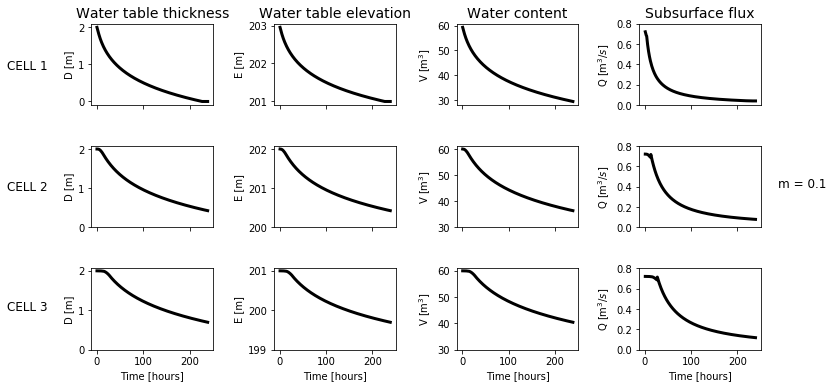

In [151]:
Qdict1 = dict(simul_results[3])
for i in Qdict1:
    Qdict1[i] = np.ndarray.tolist(Qdict1[i])[0]
Sdict1 = dict(simul_results[2])
for i in Sdict1:
    Sdict1[i] = np.ndarray.tolist(Sdict1[i])[0]
Edict1 = dict(simul_results[1])
for i in Edict1:
    Edict1[i] = np.ndarray.tolist(Edict1[i])[0]
ddict1 = dict(simul_results[0])
for i in ddict1:
    ddict1[i] = np.ndarray.tolist(ddict1[i])[0]

d_df = pd.DataFrame.from_dict(ddict1, orient='index')
E_df = pd.DataFrame.from_dict(Edict1, orient='index')
S_df = pd.DataFrame.from_dict(Sdict1, orient='index')
Q_df = pd.DataFrame.from_dict(Qdict1, orient='index')
#d_df.head()


fig, axes = plt.subplots(3, 4, sharex=True, figsize=(12,6))
axes[0,0].set_title('Water table thickness', fontsize=14)
axes[0,1].set_title('Water table elevation', fontsize=14)
axes[0,2].set_title('Water content', fontsize=14)
axes[0,3].set_title('Subsurface flux', fontsize=14)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axes[2,0].set_xlabel('Time [hours]', fontsize=10)
axes[2,1].set_xlabel('Time [hours]', fontsize=10)
axes[2,2].set_xlabel('Time [hours]', fontsize=10)
axes[2,3].set_xlabel('Time [hours]', fontsize=10)

cols = d_df.shape[1]
x = d_df.index
for i in range(cols):
    axes[i,0].plot(x, d_df[i], linewidth=3, color="k")
    axes[i,0].set_yticks([0.0, 1.0, 2.0])
    axes[i,0].set_ylabel('D [m]', fontsize=10)
    #axes[i,0].set_title('Cell ' + str(i+1), fontsize=10, horizontalalignment='left')
    plt.gcf().text(0.0275, 0.775-0.28*i, "CELL "+str(i+1), fontsize=12)
for i in range(cols):
    axes[i,1].plot(x[1:], E_df[i][1:], linewidth=3, color="k")
    axes[i,1].set_yticks([elev[0,i], elev[0,i]-1, elev[0,i]-2])
    #axes[i,1].set_title('Cell ' + str(i+1), fontsize=10, horizontalalignment='left')
    axes[i,1].set_ylabel('E [m]', fontsize=10)
for i in range(cols):
    axes[i,2].plot(x[1:], S_df[i][1:], linewidth=3, color="k")
    axes[i,2].set_yticks([30,40,50,60])
    axes[i,2].set_ylabel('V [m$^3$]', fontsize=10)
    #axes[i,2].set_title('Cell ' + str(i+1), fontsize=10, horizontalalignment='left')
for i in range(cols):
    axes[i,3].plot(x[1:], Q_df[i][1:], linewidth=3, color="k")
    axes[i,3].set_yticks([0,0.2,0.4,0.6,0.8])
    axes[i,3].set_ylabel('Q [m$^3/s$]', fontsize=10)
    #axes[i,3].set_title('Cell ' + str(i+1), fontsize=10, horizontalalignment='left')
axes[2,1].set_yticks([199,200,201])

if decaying_transmissivity == False:
    plt.gcf().text(0.92, 0.5, "No transmissivity decay", fontsize=12)
    fig.show()
    #plt.savefig("drainTheAquifer_noDecay_plots.jpg".format(m), dpi=85)
else:
    plt.gcf().text(0.92, 0.5, "m = "+str(m), fontsize=12)
    fig.show()
    #plt.savefig("drainTheAquifer_Decay{}_plots.jpg".format(m), dpi=85)
cols

[0.59113505156384, 0.6933512886728801, 0.79556752578192, 0.89778376289096, 1.0]


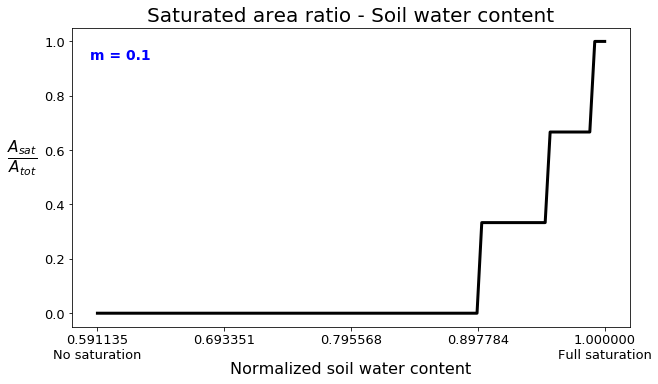

In [152]:
d_df.head()
Vsoilwater_list = []
Area_ratio_list = []
for i in d_df.index.tolist():
    saturated_area = 0
    water_volume = 0
    for j in range(3):
        if d_df.iloc[i][j] >= D-0.1:
            saturated_area += resol*resol
        water_volume += S_df.iloc[i][j]
    Area_ratio = saturated_area / (3*resol*resol)
    Vsoilwater_list.append(water_volume/180)
    Area_ratio_list.append(Area_ratio)

fig,ax = plt.subplots(figsize=(10,5.5))
ax.set_title('Saturated area ratio - Soil water content', fontsize=20)
ax.set_ylabel(r'$\frac{A_{sat}}{A_{tot}}$', fontsize=22, labelpad=22, rotation='horizontal')
ax.set_xlabel("Normalized soil water content", fontsize=16, labelpad=0, rotation='horizontal')
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=13)
spaced_xticks = [min(Vsoilwater_list),
                 min(Vsoilwater_list)+(max(Vsoilwater_list)-min(Vsoilwater_list))*0.25,
                 min(Vsoilwater_list)+(max(Vsoilwater_list)-min(Vsoilwater_list))*0.5,
                 min(Vsoilwater_list)+(max(Vsoilwater_list)-min(Vsoilwater_list))*0.75,
                 max(Vsoilwater_list)]
#spaced_xticks = [0.0, 0.25, 0.5, 0.75, 1.0]
print(spaced_xticks)
ax.set_xticks(spaced_xticks)
ax.set_xticklabels(['{:1f}'.format(spaced_xticks[0])+"\nNo saturation",
                    '{:1f}'.format(spaced_xticks[1]),
                    '{:1f}'.format(spaced_xticks[2]),
                    '{:1f}'.format(spaced_xticks[3]),
                    '{:1f}'.format(spaced_xticks[-1])+"\nFull saturation"], 
                   fontsize=13)

ax.plot(Vsoilwater_list, Area_ratio_list, color='k', linewidth=3)

if decaying_transmissivity == False:
    plt.gcf().text(0.15, 0.8, "No transmissivity decay", fontsize=14, color='blue', fontweight="bold")
    fig.show()
    #plt.savefig("satAreaRatio_SoilWaterVol_noDecay.jpg".format(m), dpi=85)
else:
    plt.gcf().text(0.15, 0.8, "m = "+str(m), fontsize=14, color='blue', fontweight="bold")
    fig.show()
    #plt.savefig("satAreaRatio_SoilWaterVol_Decay{}.jpg".format(m), dpi=85)
   

In [153]:
#ddict
d = 1
Transmissivity = (Ks*D) * np.exp(-1*(1.9-d)/0.05)
Q1 = Transmissivity * resol * slope
Q2 = Ks * d * resol * slope
#print(Q1, Q2)
Qnorm_df = pd.Dataframe(Q_df)

Q_df.to_csv("simple_dem_Q_m0.1.csv")
Ks


0.36

In [4]:
data_dir = "C:/Users/feder/Documents/CUAHSI/my_data/hubbard/"
dem_file = data_dir + "hubbard_clipped.tif"
pcr_dem_file = data_dir + "hubbard_pcr.map"
os.system('gdal_translate -of PCRaster -ot Float32' + dem_file + ' ' + pcr_dem_file)

1